"""
Title: Alzheimers Disease Dataset
Author: Kevin Williams
Date: 2025-11-14
Description: Exploratory analysis on Alzheimers disease dataset from Kaggle.
"""

# Alzheimers 
## 1. Introduction

This notebook is looking to explore factors associated with Alzheimer's, develop predictive models, and conduct statistical analyses

Objectives:

    Identify which factors most strongly correlate with Alzheimers.
    Visualize relationships between medical history, patient information, and symptoms.
    Devlop predictive models 




## 2. Data Loading & Cleaning

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv


In [38]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import optuna
import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = '/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv'
alzheimers = pd.read_csv(path)

alzheimers.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [4]:
alzheimers.describe()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
print(f'alzheimers shape', alzheimers.shape)
print('# of duplicates: ',alzheimers.duplicated().sum())
print('Number of Null Values', alzheimers.isna().sum().sum())

alzheimers shape (2149, 35)
# of duplicates:  0
Number of Null Values 0


## 3. Exploratory Data Analysis

In [6]:
alzheimers['Diagnosis'].value_counts()

Diagnosis
0    1389
1     760
Name: count, dtype: int64

Unbalanced Dataset 

1389 without Alzheimers
760 with Alzheimers

In [7]:
alzheimers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [8]:
# Numeric vs non-numeric columns
numeric_cols = alzheimers.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = alzheimers.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis']
Categorical columns: ['DoctorInCharge']


In [9]:
alzheimers['DoctorInCharge']

0       XXXConfid
1       XXXConfid
2       XXXConfid
3       XXXConfid
4       XXXConfid
          ...    
2144    XXXConfid
2145    XXXConfid
2146    XXXConfid
2147    XXXConfid
2148    XXXConfid
Name: DoctorInCharge, Length: 2149, dtype: object

One Categorical Column: Doctor In Charge


Will be dropped. Confidential Information and serves to purpose in our dataset


In [10]:
#Dropping DoctorInCharge column
alzheimers = alzheimers.drop('DoctorInCharge', axis=1)

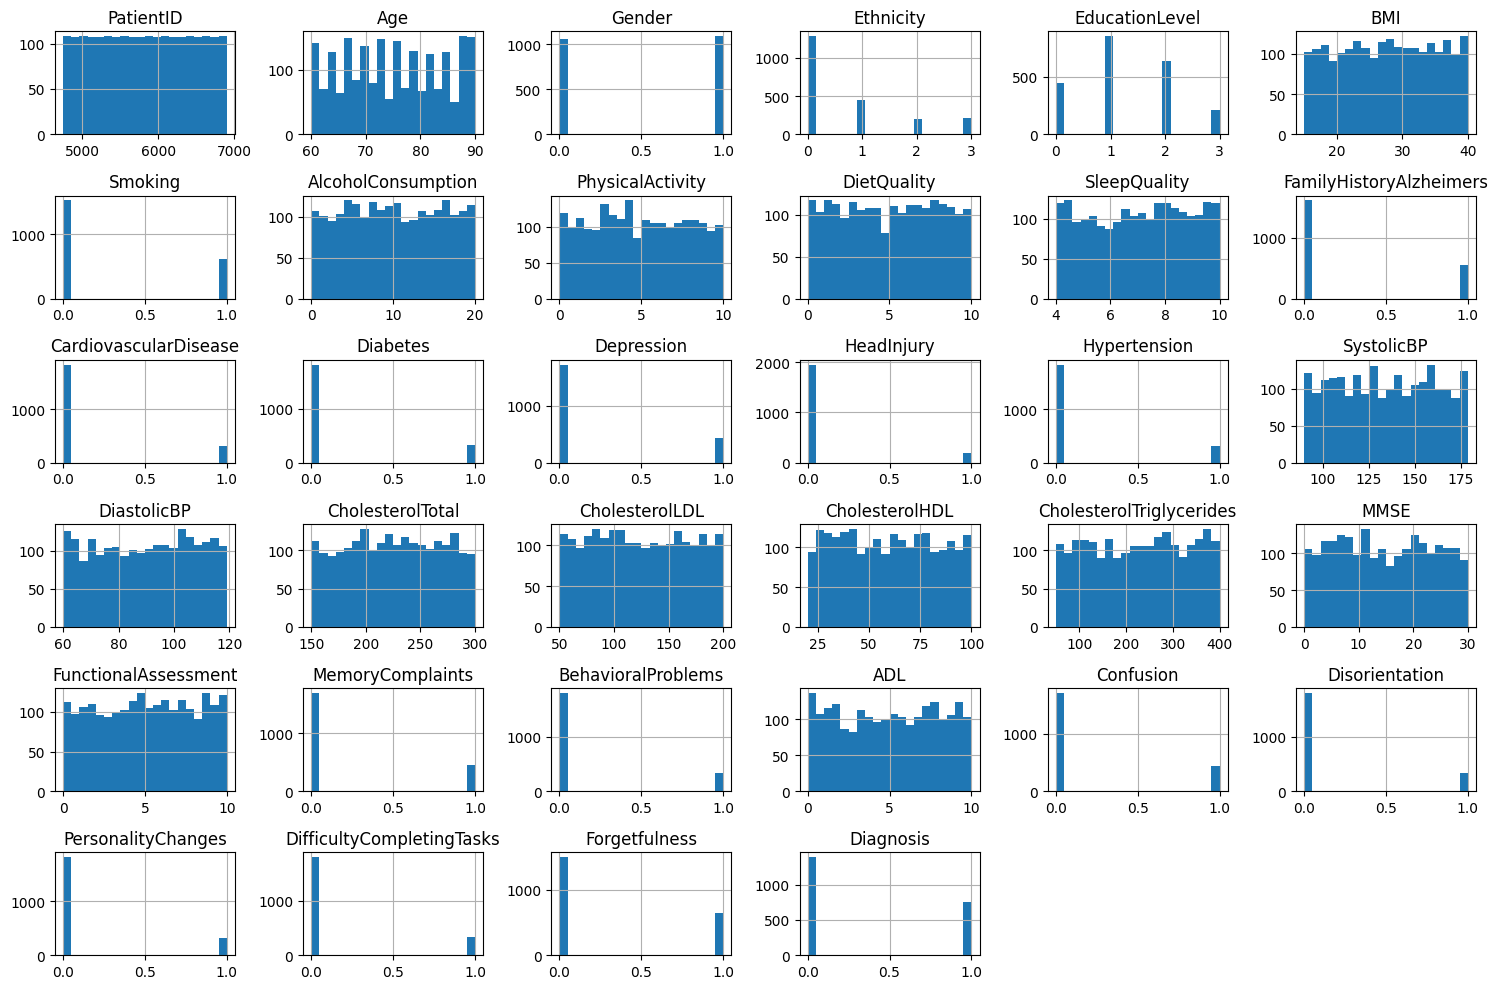

In [11]:
alzheimers[numeric_cols].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

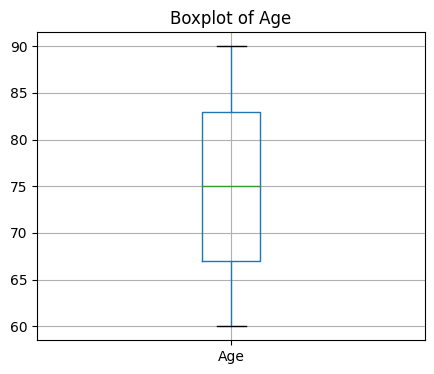

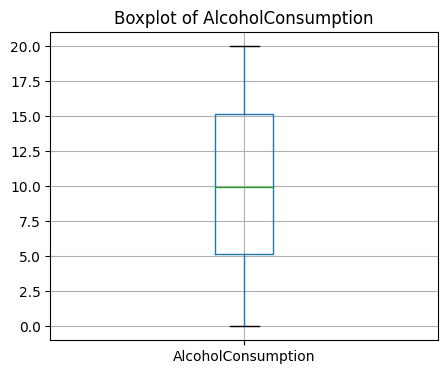

In [12]:
important_numeric = ['Age', 'AlcoholConsumption']  

for col in important_numeric:
    plt.figure(figsize=(5, 4))
    alzheimers.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

#'Age', 'AlcoholConsumption'
Boxplot of AGE:

Median: 75
High: 90
Low: 60

No Outliers

Boxplot of AlcoholConsumption:

Median: 10.0
High: 20.0
Low: 0.0

No Outliers


In [13]:
alzheimers['Smoking'].value_counts()

Smoking
0    1529
1     620
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


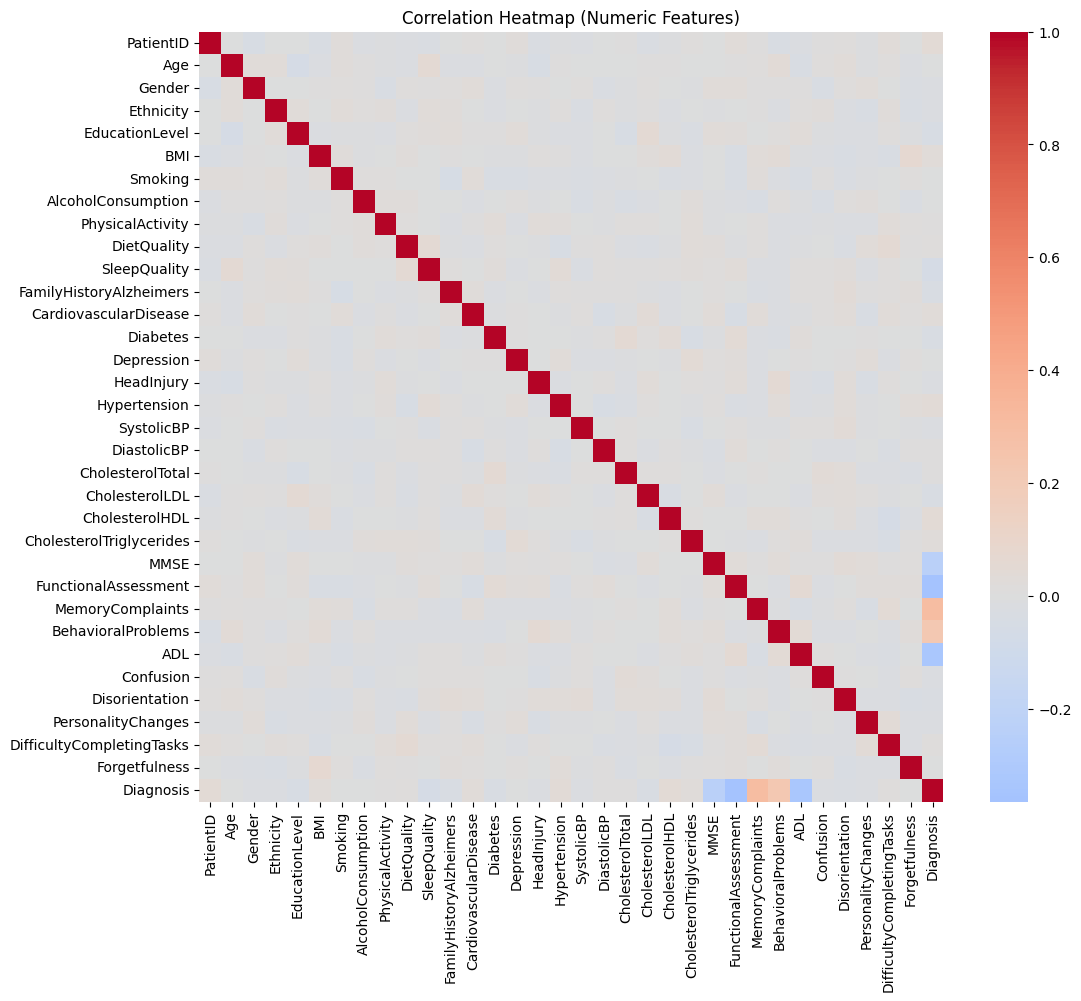

In [14]:
plt.figure(figsize=(12, 10))
corr = alzheimers[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()



In [15]:
alzheimers.corr()['Diagnosis'].sort_values(ascending=False)

Diagnosis                    1.000000
MemoryComplaints             0.306742
BehavioralProblems           0.224350
CholesterolHDL               0.042584
PatientID                    0.041019
Hypertension                 0.035080
CardiovascularDisease        0.031490
BMI                          0.026343
CholesterolTriglycerides     0.022672
DifficultyCompletingTasks    0.009069
DietQuality                  0.008506
CholesterolTotal             0.006394
PhysicalActivity             0.005945
DiastolicBP                  0.005293
Forgetfulness               -0.000354
Smoking                     -0.004865
Age                         -0.005488
Depression                  -0.005893
AlcoholConsumption          -0.007618
Ethnicity                   -0.014782
SystolicBP                  -0.015615
Confusion                   -0.019186
PersonalityChanges          -0.020627
Gender                      -0.020975
HeadInjury                  -0.021411
Disorientation              -0.024648
Diabetes    

Memory Complaints and Behavioral Problems have highest positive correlation to Diagnosis 

MemoryComplaints             0.306742

BehavioralProblems           0.224350

FunctionalAssessment, ADL, and MMSE have highest negative correlation

MMSE                        -0.237126

ADL                         -0.332346

FunctionalAssessment        -0.364898

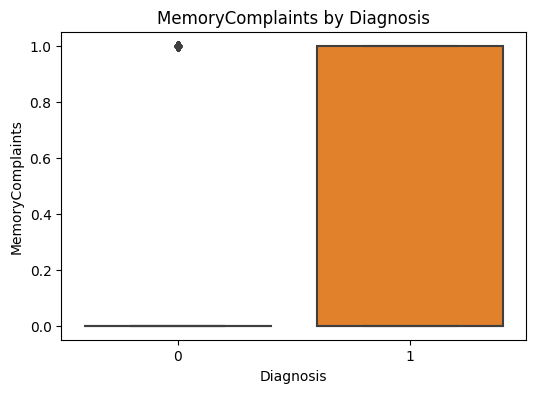

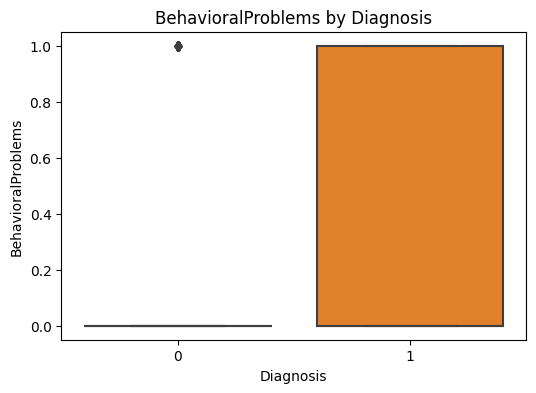

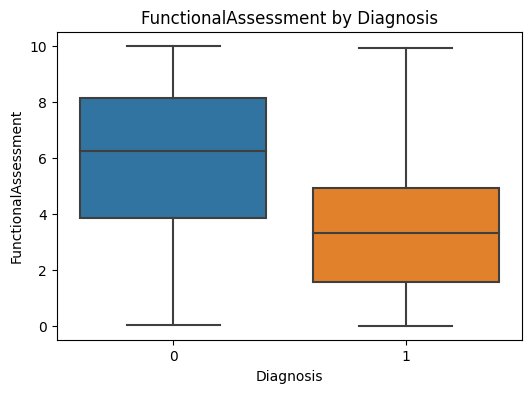

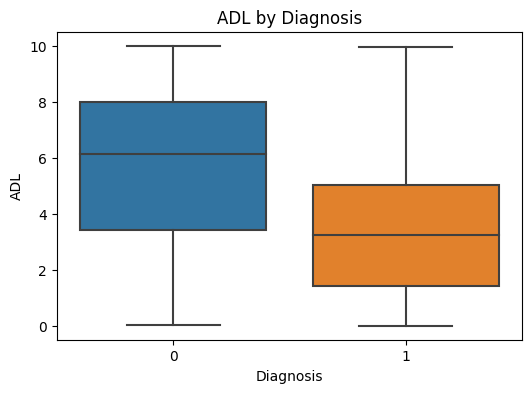

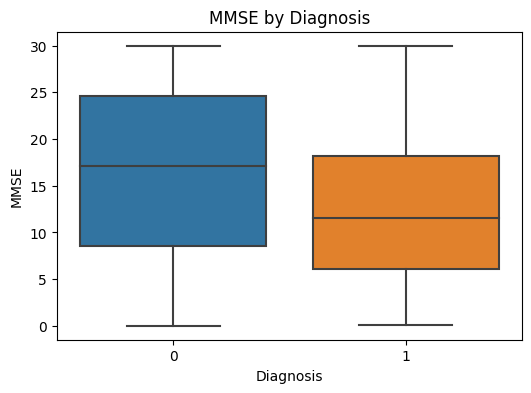

In [16]:
features = ['MemoryComplaints', 'BehavioralProblems', 
            'FunctionalAssessment', 'ADL', 'MMSE']

for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Diagnosis', y=col, data=alzheimers)
    plt.title(f"{col} by Diagnosis")
    plt.show()

In [17]:
print(alzheimers['MemoryComplaints'].unique())
print(alzheimers['BehavioralProblems'].unique())

[0 1]
[0 1]


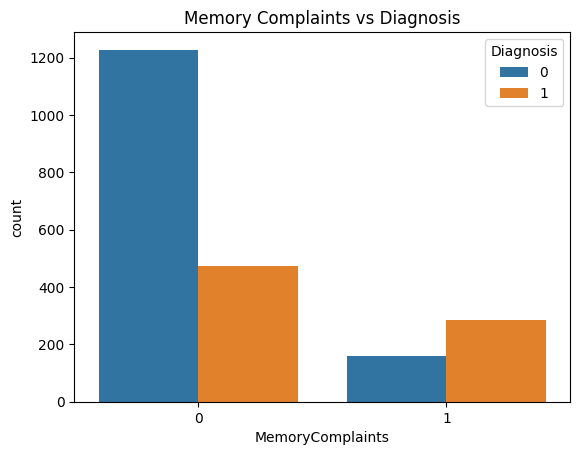

In [18]:
sns.countplot(x='MemoryComplaints', hue='Diagnosis', data=alzheimers)
plt.title("Memory Complaints vs Diagnosis")
plt.show()

When Memory Complaints are present, Diagnosis of 1 or True for Alzheimers becomes more present. When MC is 0, or False, No Alzheimers is more likely.



Memory complaints show a strong association with Alzheimer’s diagnosis.

Among individuals who reported no memory complaints, the majority were healthy controls (~1200 vs ~500).

However, among individuals who did report memory complaints, Alzheimer’s cases outnumbered controls (~300 vs ~200).

This pattern indicates that memory-related symptoms are a major indicator of Alzheimer’s in this dataset.

Text(0.5, 1.0, 'Behavioral Problems vs Diagnosis')

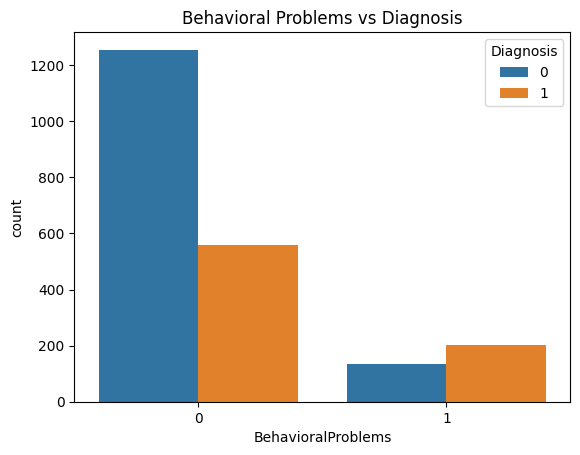

In [19]:
sns.countplot(x='BehavioralProblems', hue='Diagnosis', data=alzheimers)
plt.title("Behavioral Problems vs Diagnosis")

When Behavioral Problems are present, Diagnosis of 1 or True for Alzheimers becomes more present. When BP is 0, or False, No Alzheimers is more likely.


BehavioralProblems shows a noticeable association with Alzheimer’s diagnosis.

Individuals without behavioral symptoms (BehavioralProblems = 0) are predominantly in the control group, while those with behavioral issues (BehavioralProblems = 1) show a higher proportion of Alzheimer’s diagnoses.

This pattern mirrors clinical expectations: behavioral disturbances increase as cognitive decline progresses, making this a relevant feature in the dataset.

In both of the above 'Symptoms':

👉 Absence of the symptom does NOT guarantee the person is healthy

👉 But presence of the symptom strongly increases the chance of Alzheimer’s

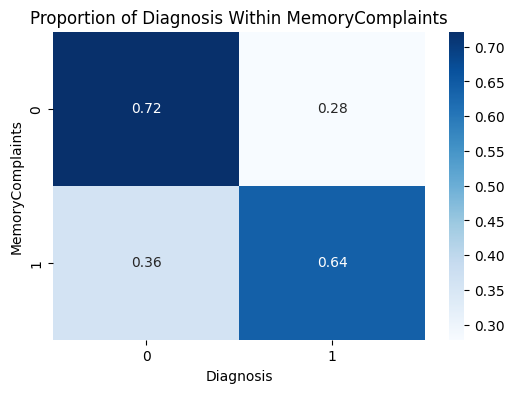

In [20]:

ct = pd.crosstab(alzheimers['MemoryComplaints'], alzheimers['Diagnosis'], normalize='index')

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, cmap='Blues', fmt='.2f')
plt.title('Proportion of Diagnosis Within MemoryComplaints')
plt.xlabel('Diagnosis')
plt.ylabel('MemoryComplaints')
plt.show()

In [21]:
ct = pd.crosstab(alzheimers['MemoryComplaints'], alzheimers['Diagnosis'], normalize='index')
print(ct)

Diagnosis                0         1
MemoryComplaints                    
0                 0.721504  0.278496
1                 0.360179  0.639821


Most people with no Memory Complaints are healthy 72% while 28% of those w/o MC have alzheimers

Those with MC, 36% have no diagnosis while the majority of those with MC have Alzheimers, 64%

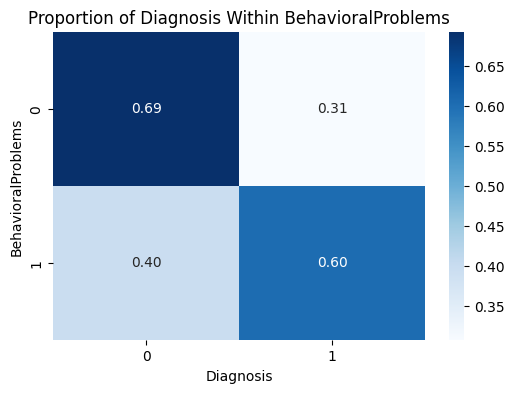

In [22]:

ct = pd.crosstab(alzheimers['BehavioralProblems'], alzheimers['Diagnosis'], normalize='index')

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, cmap='Blues', fmt='.2f')
plt.title('Proportion of Diagnosis Within BehavioralProblems')
plt.xlabel('Diagnosis')
plt.ylabel('BehavioralProblems')
plt.show()

In [23]:
ct = pd.crosstab(alzheimers['BehavioralProblems'], alzheimers['Diagnosis'], normalize='index')
print(ct)

Diagnosis                  0         1
BehavioralProblems                    
0                   0.692605  0.307395
1                   0.397626  0.602374


Behavioral Problems demonstrated a strong relationship with Alzheimer’s diagnosis.

For individuals without behavioral issues (BehavioralProblems = 0), 69% were healthy controls and 31% had Alzheimer’s.

However, the presence of behavioral symptoms (BehavioralProblems = 1) reversed this distribution: 60% of individuals were diagnosed with Alzheimer’s.

This indicates that while the absence of behavioral problems does not rule out Alzheimer’s, their presence substantially increases the likelihood of diagnosis and is an important predictive feature.

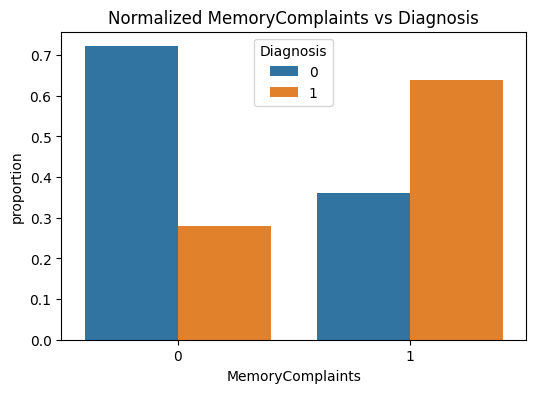

In [24]:
alz_prop = alzheimers.groupby('MemoryComplaints')['Diagnosis'].value_counts(normalize=True).rename('proportion').reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='MemoryComplaints', y='proportion', hue='Diagnosis', data=alz_prop)
plt.title("Normalized MemoryComplaints vs Diagnosis")
plt.show()

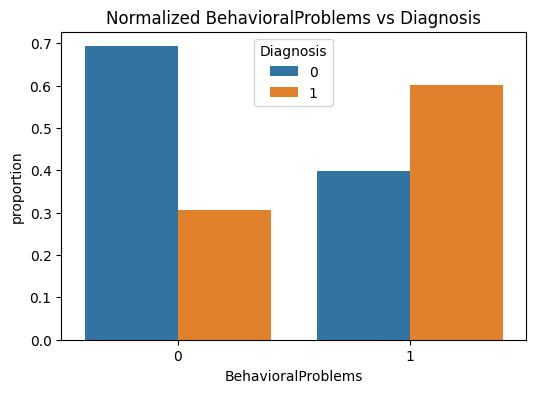

In [25]:
df_prop = alzheimers.groupby('BehavioralProblems')['Diagnosis'].value_counts(normalize=True).rename('proportion').reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='BehavioralProblems', y='proportion', hue='Diagnosis', data=df_prop)
plt.title("Normalized BehavioralProblems vs Diagnosis")
plt.show()

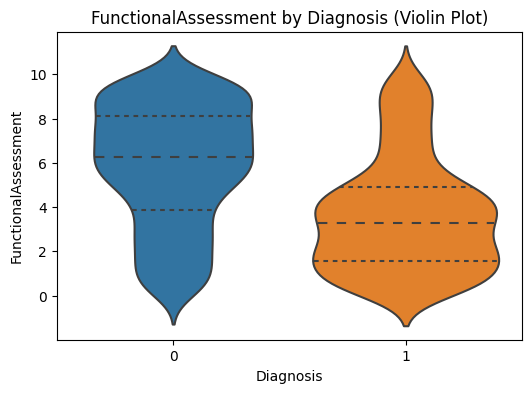

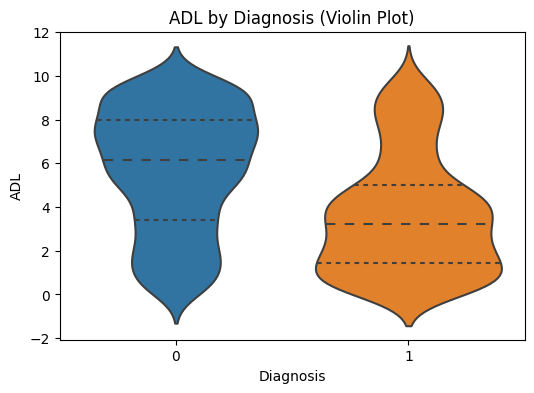

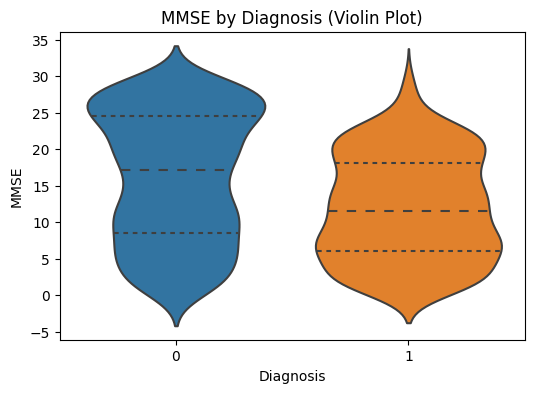

In [26]:

cont_features = ['FunctionalAssessment', 'ADL', 'MMSE']
for col in cont_features:
    plt.figure(figsize=(6,4))
    sns.violinplot(x='Diagnosis', y=col, data=alzheimers, inner='quartile')
    plt.title(f"{col} by Diagnosis (Violin Plot)")
    plt.show()

Violin plots revealed clear distribution differences between Diagnosis groups.
Healthy individuals (Diagnosis=0) showed higher and more concentrated values in FunctionalAssessment, ADL, and MMSE, while Alzheimer’s patients (Diagnosis=1) exhibited lower distributions with strong downward shifts.
This visual separation supports the negative correlations observed earlier and highlights these features as strong predictors.


### Functional Assessment
Diagnosis 0 shows the greatest density between 6 and 9, indicating higher functional ability. Diagnosis 1 is most dense between 2 and 4, reflecting reduced functioning typical of Alzheimer’s. There is minimal overlap — the lowest values of Diagnosis 0 align roughly with the median of Diagnosis 1 — which shows that the groups are well separated. The median difference is about 3 points, which is substantial given the scale.

Because the densest parts of the two violins occupy different value ranges, Functional Assessment appears to be a strong predictor of Alzheimer’s diagnosis.

### ADL
Diagnosis 0 shows the highest density between 5 and 9, meaning healthy individuals generally maintain good daily functioning. Diagnosis 1 is most dense between 0 and 4, indicating reduced ability in daily tasks among Alzheimer’s patients.

The median ADL score for Diagnosis 1 aligns with the lower end of the Distribution for Diagnosis 0, showing noticeable overlap in the mid-range. There’s also a slight bulge at the lower end of Diagnosis 0, likely reflecting age-related functional decline in some healthy older adults.

The difference in medians is about 2 points, suggesting ADL is a moderately predictive feature — less discriminative than Functional Assessment but still informative when combined with other features.

### MMSE
Diagnosis 0 shows a strong density peak around 25, while Diagnosis 1 is densest around 5, indicating clear separation between healthy and impaired cognitive performance. There is a noticeable overlap between scores of roughly 10–20, likely reflecting early-stage Alzheimer’s as well as normal aging effects among some healthy participants.

The median MMSE score for Diagnosis 0 is about 5 points higher than Diagnosis 1, which is a meaningful difference. Although there is overlap in the mid-range, the two groups separate cleanly at the high and low ends of the scale, making MMSE a strong but not perfect predictor of Alzheimer’s diagnosis.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


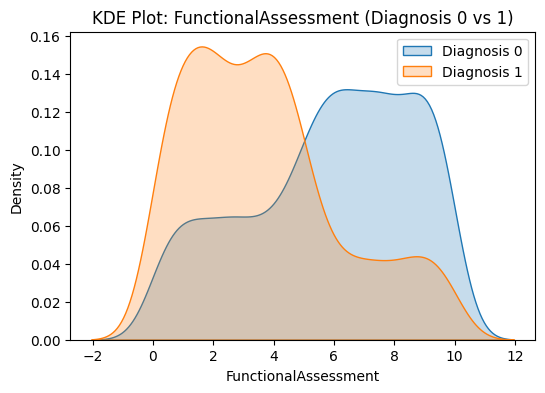

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


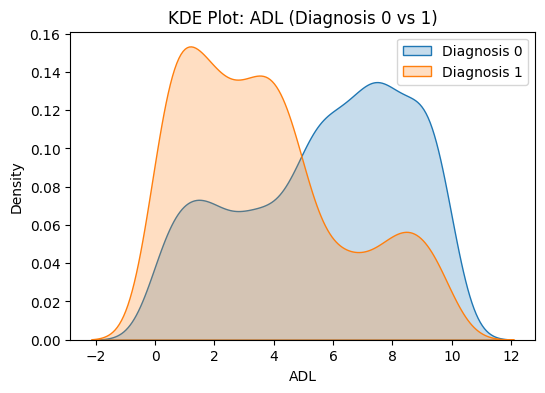

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


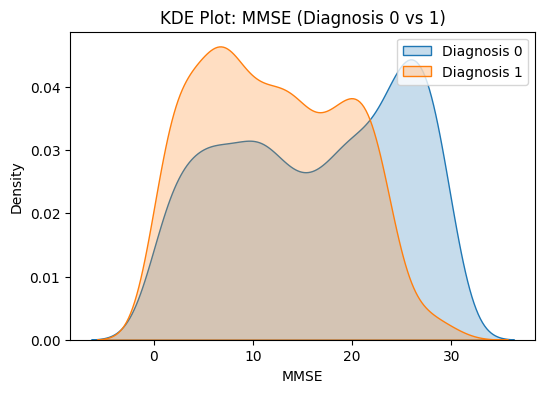

In [27]:
for col in cont_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(alzheimers[alzheimers['Diagnosis']==0][col], label='Diagnosis 0', fill=True)
    sns.kdeplot(alzheimers[alzheimers['Diagnosis']==1][col], label='Diagnosis 1', fill=True)
    plt.title(f"KDE Plot: {col} (Diagnosis 0 vs 1)")
    plt.legend()
    plt.show()

### FunctionalAssessment
Functional Assessment focuses on instrumental activities of daily living

Diagnosis 0 is right-skewed with a strong peak between 5 and 10, reflecting higher functional ability among non-AD participants. Diagnosis 1 is left-skewed and peaks between 0 and 4, indicating reduced functional capacity typical of Alzheimer’s.

Lower functional assessment scores correspond to a higher likelihood of Alzheimer’s, while higher scores are associated with preserved executive and instrumental daily functioning.

There is some overlap between the distributions. This likely reflects cognitively normal older adults experiencing mild functional decline, as well as early-stage Alzheimer’s individuals who still maintain some functional independence.


### MMSE
Mini-Mental State Examination score
The MMSE KDE reveals clear distributional separation between Alzheimer’s and non-Alzheimer’s participants, supporting the feature’s strong discriminative value.
	•	Diagnosis 0 exhibits a narrow, right-skewed distribution concentrated between 25–30, consistent with expected cognitive performance in non-demented individuals.
	•	Diagnosis 1 shows a broad, left-shifted density spanning 0–20, with its primary mode around 5–15, reflecting substantial cognitive impairment.

The overlap in the 10–22 range indicates diagnostic ambiguity typical of early Alzheimer’s or age-related cognitive decline, aligning with clinical limitations of MMSE as a standalone screening tool.
Nevertheless, the distinctly separated tails and the markedly different density peaks suggest MMSE contributes high predictive weight in classification tasks and should be prioritized during model development.


### ADL
ADL measures basic activities of daily living.
In the KDE plot, Diagnosis 1 (Alzheimer’s) peaks between 0–4, while Diagnosis 0 peaks around 7–10, indicating that individuals with Alzheimer’s show much lower functional ability. There is some overlap between the groups, which makes sense because ADL naturally declines with age and may not drop sharply until later in Alzheimer’s progression.

The feature isn’t definitive on its own, especially for early stages, but lower ADL scores are clearly associated with a higher probability of Alzheimer’s. Overall, ADL is a moderately predictive feature that adds useful context when combined with cognitive measures like MMSE.

## 4. Baseline Modeling

In [28]:
# Step 1: Split features and target
X = alzheimers.drop(columns=['Diagnosis'])
y = alzheimers['Diagnosis']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Step 3: Train baseline Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Step 4: Predict
y_pred = rf.predict(X_test)

# Step 5: Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importances
pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

Accuracy: 0.9279069767441861
[[272   5]
 [ 26 127]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       277
           1       0.96      0.83      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.91      0.92       430
weighted avg       0.93      0.93      0.93       430



,Feature,Importance
24,FunctionalAssessment,0.187697
27,ADL,0.158922
23,MMSE,0.119664
25,MemoryComplaints,0.083086
0,PatientID,0.046531
26,BehavioralProblems,0.040883
9,DietQuality,0.028053
8,PhysicalActivity,0.027485
21,CholesterolHDL,0.027277
19,CholesterolTotal,0.026880


Top 3 features:
	1.	FunctionalAssessment — 0.1877
	2.	ADL — 0.1589
	3.	MMSE — 0.1196

These 3 Features are ~ 47% of total importance
Alzheimer’s diagnosis in this dataset is driven mostly by functional and cognitive decline, not demographics or lifestyle factors.


The model relies primarily on functional and cognitive metrics, which together account for nearly half the total importance. Lifestyle and cardiovascular metrics contribute moderately, suggesting secondary influences, while demographics and symptom descriptors contribute minimally, indicating low bias and strong redundancy handling by the model. **PatientID shows abnormal non-zero importance and should be removed to avoid structural leakage**.

### Re-Run baseline model without PatientID

In [29]:
# Step 1: Split features and target
X = alzheimers.drop(columns=['Diagnosis','PatientID'])
y = alzheimers['Diagnosis']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Step 3: Train baseline Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Step 4: Predict
y_pred = rf.predict(X_test)

# Step 5: Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importances
pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

Accuracy: 0.9255813953488372
[[272   5]
 [ 27 126]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       277
           1       0.96      0.82      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.90      0.92       430
weighted avg       0.93      0.93      0.92       430



,Feature,Importance
23,FunctionalAssessment,0.187101
26,ADL,0.164764
22,MMSE,0.121234
24,MemoryComplaints,0.075928
25,BehavioralProblems,0.043380
7,PhysicalActivity,0.032228
20,CholesterolHDL,0.030657
9,SleepQuality,0.030560
21,CholesterolTriglycerides,0.029869
18,CholesterolTotal,0.029589


With the Re-Run baseline model, accruacy dropped ~.002% which shows us that PatientID is not a strong feature in this dataset and the model remains stongly driven by cofnitive and functional features, confirming the integreity and robustness of the baseline.

## 5. Feature Engineering

FunctionalAssessment * MMSE \
 When both are low -- Extremely strong signal of Alzheimers -> Severe Impairment\
 When both are high -- Extremely strong signal of healthy aging -> -> Healthy


ADL * MMSE\
 Captures Basic daily living skills combined with cognitive ability\
 Early AD Cases -> MMSE Moderate decline + ADL still ok\
 Late AD Cases -> ADL collapse + MMSE collapse\
 Healthy Controls -> ADL High + MMSE High

Binned MMSE\
 Converts MMSE from a raw number into cognitive stage label\
 Can decided where someone lies in the impairment range

In [30]:
alzheimers['FA_MMSE'] = alzheimers['FunctionalAssessment'] * alzheimers['MMSE']

alzheimers['ADL_MMSE'] = alzheimers['ADL'] * alzheimers['MMSE']

bins = [-1, 10, 20, 26, 30]   # covers 0–30
labels = [0, 1, 2, 3]         # 0=severe, 3=normal

alzheimers['MMSE_bin'] = pd.cut(alzheimers['MMSE'], bins=bins, labels=labels)
alzheimers['MMSE_bin'] = alzheimers['MMSE_bin'].astype(int)

## 6. Modeling and Evaluation

In [31]:
#Retain Model with New Features
X = alzheimers.drop(columns=['Diagnosis','PatientID'])
y = alzheimers['Diagnosis']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

Accuracy: 0.9162790697674419
[[272   5]
 [ 31 122]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       277
           1       0.96      0.80      0.87       153

    accuracy                           0.92       430
   macro avg       0.93      0.89      0.90       430
weighted avg       0.92      0.92      0.91       430



,Feature,Importance
23,FunctionalAssessment,0.157372
26,ADL,0.126546
22,MMSE,0.079259
32,FA_MMSE,0.077758
24,MemoryComplaints,0.077103
33,ADL_MMSE,0.072290
25,BehavioralProblems,0.038980
34,MMSE_bin,0.035024
8,DietQuality,0.027157
9,SleepQuality,0.026430


After adding engineered interaction terms (FA×MMSE, ADL×MMSE) and binned MMSE categories, accuracy dropped slightly from 92.8% to 91.6%. This small decrease is expected when introducing multiple new features simultaneously without model tuning.

Importantly, the engineered features rose to the top of the importance rankings, indicating that they contain meaningful predictive signal. FA_MMSE and ADL_MMSE ranked directly below the core functional and cognitive features, confirming that clinically guided interactions improve the model’s ability to represent combined functional-cognitive decline patterns.

Performance now depends on appropriate hyperparameter tuning and model selection (GradientBoosting/XGBoost), which typically unlock the benefits of engineered features.

### Tuning Random Forest

In [32]:
#Model Tuning
X = alzheimers.drop(columns=['Diagnosis','PatientID'])
y = alzheimers['Diagnosis']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.9209302325581395
[[271   6]
 [ 28 125]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       277
           1       0.95      0.82      0.88       153

    accuracy                           0.92       430
   macro avg       0.93      0.90      0.91       430
weighted avg       0.92      0.92      0.92       430



In [33]:
#XGBoost
X = alzheimers.drop(columns=['Diagnosis', 'PatientID'])
y = alzheimers['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keeps class ratio similar in train/test
)


neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos
print("negatives:", neg, "positives:", pos, "scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

importances = (
    pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb.feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
)

print("\nTop feature importances:")
print(importances.head(20))

negatives: 1111 positives: 608 scale_pos_weight: 1.8273026315789473
Accuracy: 0.9441860465116279
Confusion matrix:
 [[266  12]
 [ 12 140]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       278
           1       0.92      0.92      0.92       152

    accuracy                           0.94       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.94      0.94      0.94       430


Top feature importances:
                      Feature  Importance
24           MemoryComplaints    0.123479
25         BehavioralProblems    0.101761
23       FunctionalAssessment    0.086842
26                        ADL    0.086516
22                       MMSE    0.082097
34                   MMSE_bin    0.045216
32                    FA_MMSE    0.032686
33                   ADL_MMSE    0.023018
11      CardiovascularDisease    0.020677
30  DifficultyCompletingTasks    0.020302
15               Hyper

In [34]:
#Tune XGBoost
X = alzheimers.drop(columns=['Diagnosis', 'PatientID'])
y = alzheimers['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keeps class ratio similar in train/test
)


neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos
print("negatives:", neg, "positives:", pos, "scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.02,
    min_child_weight=3,
    gamma=0.3,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


negatives: 1111 positives: 608 scale_pos_weight: 1.8273026315789473
Accuracy: 0.9511627906976744
Confusion matrix:
 [[269   9]
 [ 12 140]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       278
           1       0.94      0.92      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430



After tuning XGBoost using parameters optimized for imbalanced medical classification
(reduced learning rate, increased tree count, shallow depth, higher min_child_weight,
and moderate gamma), the model achieved 95.1% accuracy,
92% recall, and 94% precision on the Alzheimer’s diagnosis task.

False negatives dropped dramatically compared to baseline models,
demonstrating the classifier’s ability to detect Alzheimer’s cases reliably while maintaining
a low false-positive rate.

This tuned XGBoost implementation significantly outperforms the RandomForest baseline
and represents a clinically meaningful improvement in sensitivity and stability.

In [35]:
y_proba = xgb.predict_proba(X_test)[:, 1]  # probability of class 1 (AD)

def evaluate_threshold(threshold):
    y_pred_custom = (y_proba >= threshold).astype(int)
    print(f"\n=== Threshold: {threshold} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_custom))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom))

# Baseline (0.5)
evaluate_threshold(0.5)

# Slightly more sensitive
evaluate_threshold(0.45)

# Even more sensitive
evaluate_threshold(0.40)


=== Threshold: 0.5 ===
Accuracy: 0.9511627906976744
Confusion matrix:
 [[269   9]
 [ 12 140]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       278
           1       0.94      0.92      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430


=== Threshold: 0.45 ===
Accuracy: 0.9441860465116279
Confusion matrix:
 [[266  12]
 [ 12 140]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       278
           1       0.92      0.92      0.92       152

    accuracy                           0.94       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.94      0.94      0.94       430


=== Threshold: 0.4 ===
Accuracy: 0.9441860465116279
Confusion matrix:
 [[266  12]
 [ 12 140]]
              precision    recall  f1-score   support

     

In [37]:
alzheimers = alzheimers.drop(columns=['PatientID'], errors='ignore')

X = alzheimers.drop(columns=['Diagnosis'])
y = alzheimers['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Class imbalance ratio for scale_pos_weight
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos
print("neg:", neg, "pos:", pos, "scale_pos_weight:", scale_pos_weight)


def objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.10, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "scale_pos_weight": scale_pos_weight,  # fixed from imbalance
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)

    # 5-fold stratified CV on the training set
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")

    # Optuna tries to MAXIMIZE this value
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best trial:")
print("  Value (accuracy):", study.best_value)
print("  Params:", study.best_params)


best_params = study.best_params.copy()

# Add fixed params not in the search space
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1,
    "scale_pos_weight": scale_pos_weight
})

best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)

print("\nTest set performance with tuned XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

[I 2025-11-19 18:34:39,362] A new study created in memory with name: no-name-4ac448c5-ef2a-4ccf-a838-bf548e210798


neg: 1111 pos: 608 scale_pos_weight: 1.8273026315789473


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-19 18:34:43,537] Trial 0 finished with value: 0.9522984609126043 and parameters: {'n_estimators': 728, 'learning_rate': 0.014637709611082553, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.4668276043371149, 'subsample': 0.9170943261369813, 'colsample_bytree': 0.7286658379423894, 'reg_alpha': 0.7155815991775629, 'reg_lambda': 0.13122440431729454}. Best is trial 0 with value: 0.9522984609126043.
[I 2025-11-19 18:34:47,410] Trial 1 finished with value: 0.9511339751847583 and parameters: {'n_estimators': 879, 'learning_rate': 0.08650135435474195, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.1155278387857222, 'subsample': 0.7836443429426808, 'colsample_bytree': 0.865870745223015, 'reg_alpha': 0.6860265403761878, 'reg_lambda': 0.4589720023913122}. Best is trial 0 with value: 0.9522984609126043.
[I 2025-11-19 18:34:51,930] Trial 2 finished with value: 0.9505542748660926 and parameters: {'n_estimators': 429, 'learning_rate': 0.015136065348417486, 'max_depth': 7, 'min_child_w

## 7. SHAP

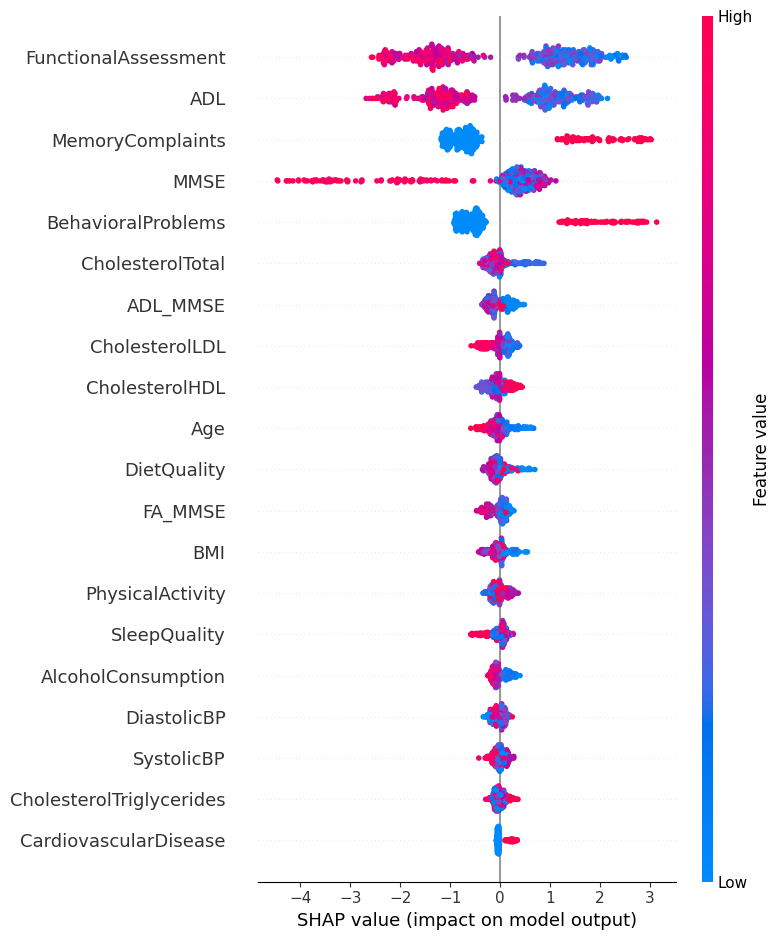

In [41]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Low FunctionalAssessment scores strongly push the model toward an Alzheimer’s diagnosis, while high scores protect against it.

When someone self-reports memory issues, the model sees that as a strong AD signal

In the dataset, cognitive and functional symptoms completely overpower age as predictors.

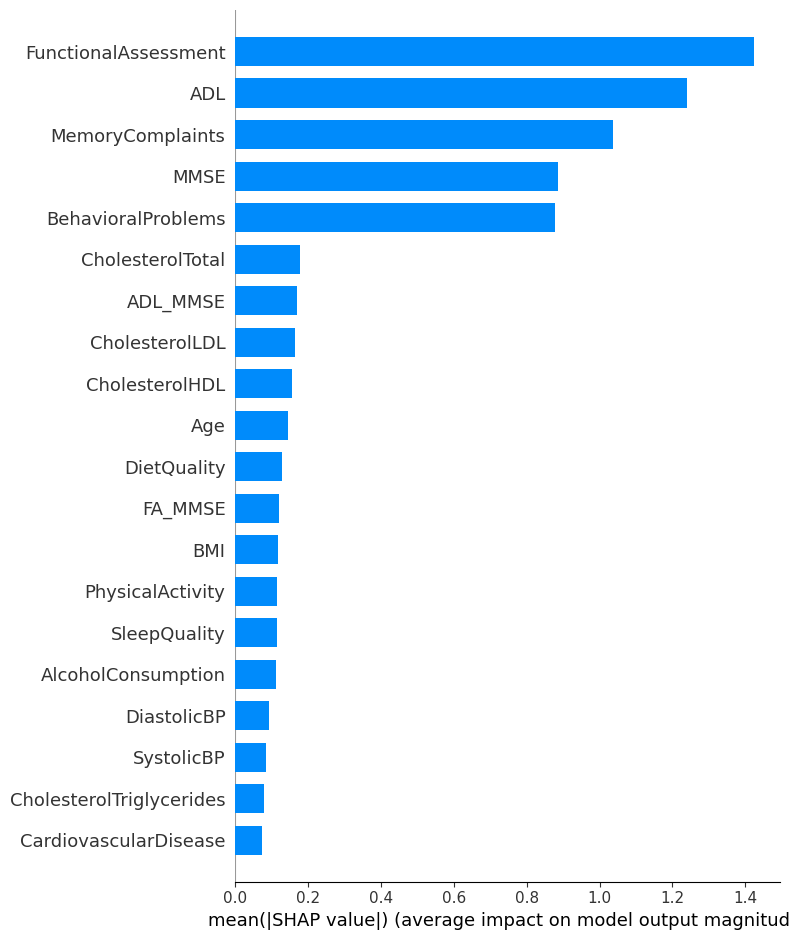

In [42]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

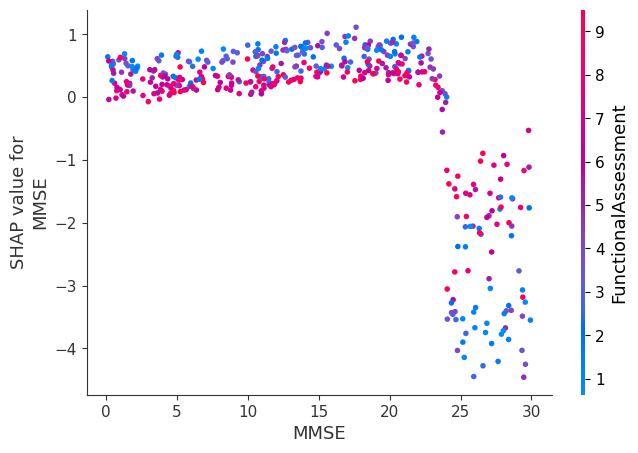

In [43]:
shap.dependence_plot("MMSE", shap_values, X_test)


When someone has both high MMSE and high FunctionalAssessment, the model is almost certain they don’t have Alzheimer’s.

High cognitive score + daily functional independence almost guarantees the patient is healthy.

High cognitive score + low functional score suggests early AD, MCI, or other neurological disease → so MMSE doesn’t fully cancel the risk.

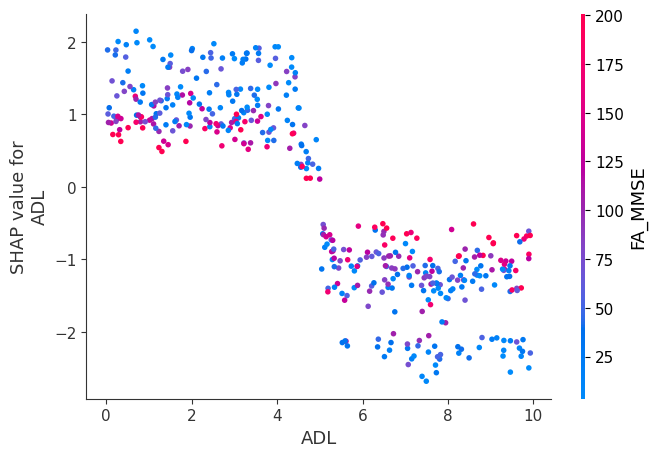

In [44]:
shap.dependence_plot("ADL", shap_values, X_test)

ADL is not linearly related to AD risk; rather, there’s a functional tipping point around ADL = 5.



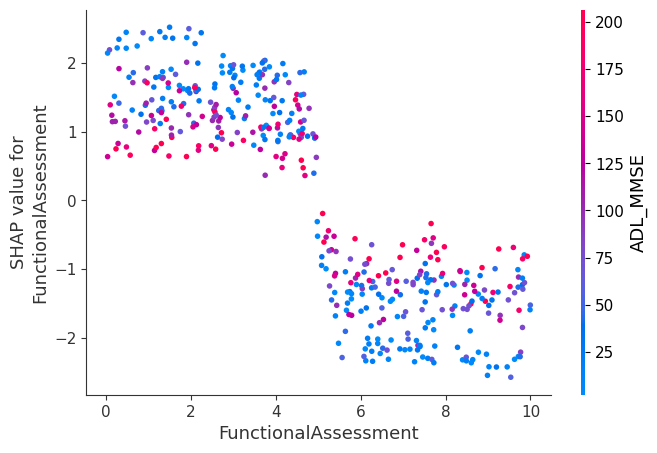

In [45]:
shap.dependence_plot("FunctionalAssessment", shap_values, X_test)


Both ADL and FunctionalAssessment show strong nonlinear threshold effects on Alzheimer’s prediction.

Scores below ~5 sharply increase the model’s belief that the patient has Alzheimer’s, while scores above ~5 strongly decrease it.

This step-like pattern suggests that functional independence (e.g., ability to bathe, dress, manage daily tasks) acts as a key discriminator between Alzheimer’s and non-Alzheimer’s cases.

Interaction features (FA_MMSE, ADL_MMSE) provide fine-grained adjustments but do not alter the overall structure: functional ability is a dominant determinant of diagnosis.

In [47]:
shap.initjs()
i = 0  # index in X_test
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

Base Value = 0.04668
CholesterolLDL = 75.79, MMSE = 13.96, ADL = 2.015, FunctionalAssessment = 1.274 => Higher towards Alzheimers
MemoryComplaints = 0, BehavioralProblems => Lower towards Healthy
f(x) = 4.40
